In [3]:
# here I'll compares how classical neural networks differ from FGNs
#     (done here on the converted (not trained) FGNs)
# when performing an Method 1 - Optimizing for noise attack against them

In [4]:
from __future__ import print_function

In [5]:
import numpy as np
import os, sys, pickle
import random

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

from scipy import stats

import torch_helper_lib as th

import json

In [7]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
print("Using device:", device)

# manualy set cuda device
torch.cuda.set_device(1)

CUDA Available:  True
Using device: cuda


In [8]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt

In [9]:
# DEFINE NETWORK that adds a tiny noise to input and then passes to another, pre-given network network
class Net(nn.Module):
    def __init__(self, pre_net):
        super(Net, self).__init__()
        self.pre_net = pre_net
        self.r = nn.Parameter(data=torch.zeros(1,28*28), requires_grad=True) # really small initial values

    def forward(self, x):
        # add noise to input
        x = x.float() + self.r 
        # clamp input to [0-1]
        x = torch.clamp(x, 0, 1)
        # apply pre-given network
        x = self.pre_net(x)
        return x

In [10]:
# create fgn model or classic model to test

mode = 'classic'

hidden_layers = [1024,1024]
exp_num = 11
if mode=='fgn':
    pre_net = th.Feedforward_FGN_net(hidden_l_nums=hidden_layers, in_feats=28*28, out_feats=10)
    weights = "./saved_models/Converted_MNIST_Nets/fgn_model_{}_exp_{}_state_dict.pth".format(hidden_layers, exp_num)
    pre_net.load_state_dict(torch.load(weights))
if mode=='classic':
    pre_net = th.Classic_MNIST_Net(hidden_l_nums=hidden_layers)
    weights = "./saved_models/Classic_MNIST_Nets/model_{}_exp_{}_state_dict.pth".format(hidden_layers, exp_num)
#     print("State Dict:", weights)
    pre_net.load_state_dict(torch.load(weights))

pre_net.to(device)

Classic_MNIST_Net(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (fl): Linear(in_features=1024, out_features=10, bias=True)
)

In [11]:
# from attack import Attack 
class Attack:
    def __init__(self, pre_net, device):
        self.device = device
        self.net = Net(pre_net)
        self.net.to(device)
        self.softmaxwithxent = nn.CrossEntropyLoss()
        # (original code, old, uses SGD)
#         self.optimizer       = optim.SGD(params=[self.net.r], lr=0.008)
        # (original PAPER, uses LBFGS)
        self.optimizer = optim.LBFGS(params=[self.net.r], lr=0.8)

#     def load_weights(self, weights=None):
#         assert os.path.isfile(weights), "Error: weight file {} is invalid".format(weights)
#         # LOAD PRE-TRAINED WEIGHTS 
#         weights_dict = {} 
#         with open(weights, "r") as f:
#             weights_dict = pickle.load(f)
#         for param in self.net.named_parameters():
#             if param[0] in weights_dict.keys():
#                 print "Copying: ", param[0]
#                 param[1].data = weights_dict[param[0]].data 
#         print "Weights Loaded!"

    def attack(self, x, y_true, y_target, regularization=None):
        """
        This method uses the method described in the paper
        "Intriguing properties of neural networks" to find a 
        noise vector 'r' that misclassifies 'x' as 'y_target'. 

        Parameters
        ----------
        x: a numpy array containing an mnist example 
        y_target: target label for attack. (int) 
        y_true: true label for x (int)

        Returns
        -------
        noise: Numpy array (1x784) of the noise to be added to x 
        y_pred: Prediction before adversarial optimization  
        y_pred_adversarial: Prediction after adversarial optimization 
        """

        _x = Variable(torch.FloatTensor(x)).to(self.device)
        _y_target = Variable(torch.LongTensor([y_target])).to(self.device)

        # Reset value of r 
        self.net.r.data = torch.zeros(1,784).to(self.device)

        # Classification before modification 
        y_pred =  np.argmax(self.net(_x).data.cpu().numpy())
        incorrect_classify = False
        # print "Y_TRUE: {} | Y_PRED: {}".format(_y_true, y_pred)
        if y_true != y_pred:
            incorrect_classify = True
            print ("WARNING: IMAGE WAS NOT CLASSIFIED CORRECTLY")

        # Optimization Loop 
        for iteration in range(1000):

#             self.optimizer.zero_grad() 
#             outputs = self.net(_x)
#             xent_loss = self.softmaxwithxent(outputs, _y_target) 

#             if regularization == "l1":
#                 adv_loss = xent_loss + torch.mean(torch.abs(self.net.r))
#             elif regularization == "l2":
#                 adv_loss  = xent_loss + torch.mean(torch.pow(self.net.r,2))
#             elif regularization == None:
#                 adv_loss = xent_loss
#             else:
#                 raise Exception("regularization method {} is not implemented, please choose one of l1, l2 or None".format(regularization))

            # required for LBFGS
            def closure():
                if torch.is_grad_enabled():
                    self.optimizer.zero_grad()
                outputs = self.net(_x)
                xent_loss = self.softmaxwithxent(outputs, _y_target) 
                if regularization == "l1":
                    adv_loss = xent_loss + torch.mean(torch.abs(self.net.r))
                elif regularization == "l2":
                    adv_loss  = xent_loss + torch.mean(torch.pow(self.net.r,2))
                elif regularization == None:
                    adv_loss = xent_loss
                else:
                    raise Exception("regularization method {} is not implemented, please choose one of l1, l2 or None".format(regularization))
                if adv_loss.requires_grad:
                    adv_loss.backward()
                return adv_loss
            
            # not part of LBFGS
#             adv_loss.backward() 
            self.optimizer.step(closure) 

            # keep optimizing Until classif_op == _y_target
            y_pred_adversarial = np.argmax(self.net(_x).data.cpu().numpy())
            if y_pred_adversarial == y_target:
                print("Attack succesful")
                break 

        if iteration == 999:
            print ("Warning: optimization loop ran for 1000 iterations. The result may not be correct")

        return self.net.r.data.cpu().numpy(), y_pred, y_pred_adversarial 

In [12]:
# Load 5K samples 
with open("../Adversarial-Examples-in-PyTorch/5k_samples.pkl","r") as f: 
    samples_5k = pickle.load(f) 
images = samples_5k["images"]
labels = samples_5k["labels"]


mnist5k_dataset = torch.utils.data.TensorDataset(torch.Tensor([(x-0.1307)/0.3081 for x in samples_5k['images']]).to(device), 
                                                 torch.Tensor(samples_5k['labels']).to(device)
                                                  )# create your dataset
mnist5k_dataloader = torch.utils.data.DataLoader(mnist5k_dataset,
                                                 batch_size=32,
                                                 shuffle=False ) # create your dataloader

In [13]:
# MNIST dataset and dataloader declaration
# transforms does both the conversion from 0-255 to 0-1
# and normalizes by the precomputed mean and std

batch_size = 64

mnist_train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../MNIST-dataset', train=True, download=False, 
                   transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))
            ])), 
        batch_size=batch_size, shuffle=False)

mnist_test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../MNIST-dataset', train=False, download=False, 
                   transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))
            ])), 
        batch_size=batch_size, shuffle=False)

<IPython.core.display.Javascript object>


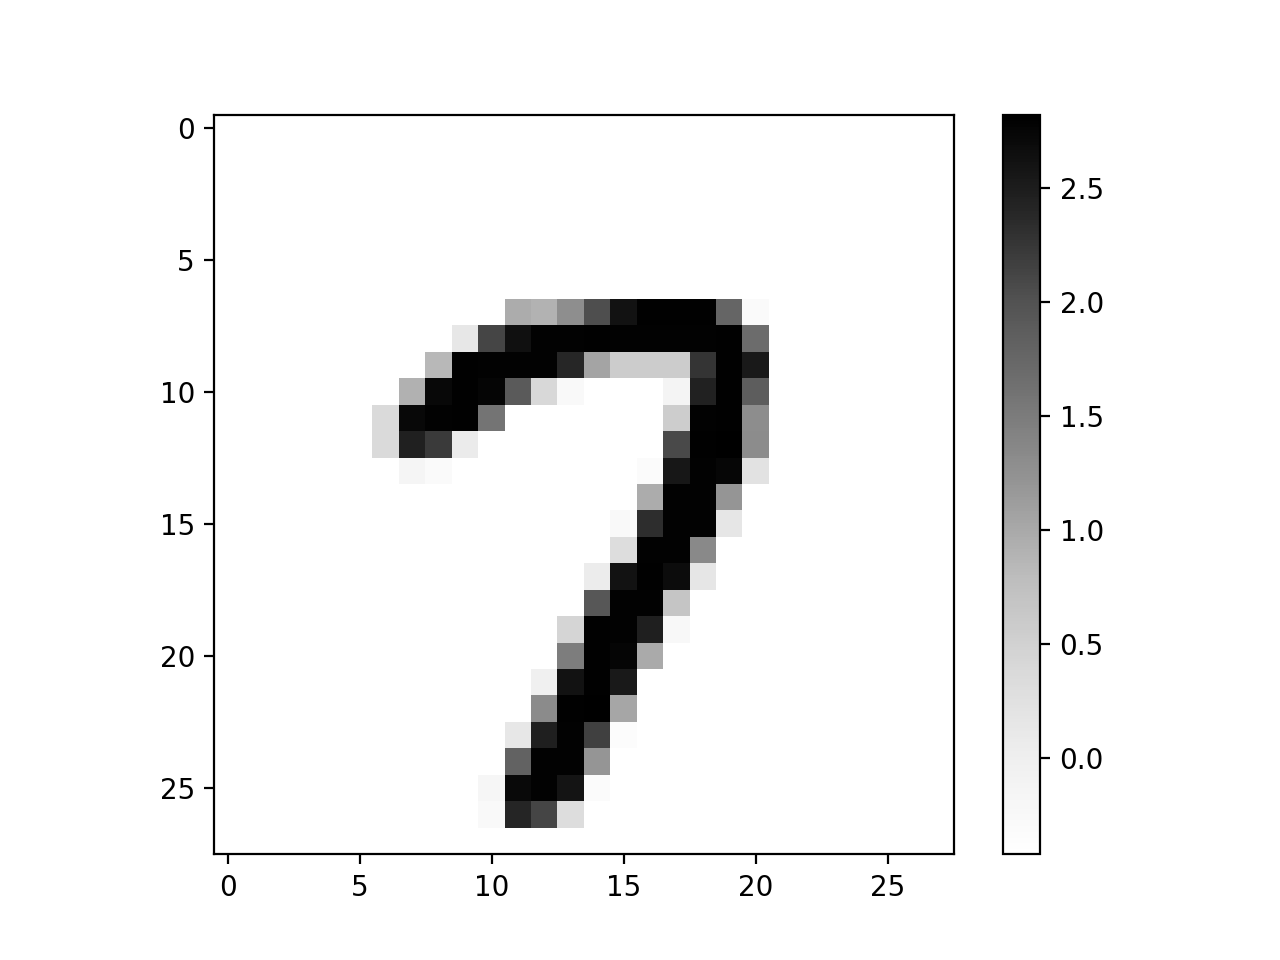

In [14]:
# test network
x = mnist5k_dataloader.dataset[0][0].cpu()
x = np.reshape(x, newshape=(28,28))
plt.imshow(x, cmap=plt.cm.get_cmap('Greys'))
plt.colorbar()
plt.show()

In [15]:
# nll loss function
def fgn_nll_loss_func(model, output, target):
#     # split output into pred and likelihoods
#     output, likelihood = output
    return F.nll_loss(output, target.long())    
# number of correct pred function for fgnet
def fgn_pred_func(output, target):
#     # split output into pred and likelihoods
#     output,_ = output
    pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
    correct = pred.eq(target.long().view_as(pred)).sum().item()
    return correct

In [16]:
# test accuracy
th.test(model=pre_net, device=device, test_loader=mnist_test_loader, loss_func=fgn_nll_loss_func, pred_func=fgn_pred_func, verbose=2)
th.test(model=pre_net, device=device, test_loader=mnist5k_dataloader, loss_func=fgn_nll_loss_func, pred_func=fgn_pred_func, verbose=2)

Test set - Average loss: 0.1105, Accuracy: 9660/10000 (97%)
Test set - Average loss: 0.1046, Accuracy: 4841/5000 (97%)


{'test_accuracy': 96.82, 'test_loss': 0.10458709697723388}

In [17]:
# Aggregate
xs, y_trues, y_preds, y_preds_adversarial, noises = [], [], [], [], []

In [18]:
# Create attacker for this network
attacker = Attack(pre_net,device)

In [20]:
# attack each example
for x, y_true in zip(images[0:100], labels[0:100]):

    y_target = random.choice( list(set([0,1,2,3,4,5,6,7,8,9]) - set([y_true])) ) 
    noise, y_pred, y_pred_adversarial = attacker.attack(x, y_true, y_target, regularization=None)
    
    if y_pred == y_true:
#         print ("y_pred == y_true, storing to disk")
        
        # store
        xs.append(x)
        y_trues.append(y_true)
        y_preds.append(y_pred)
        y_preds_adversarial.append(y_pred_adversarial)
        noises.append(noise.squeeze())
    else: 
        print ("y_pred != y_true, not storing to disk") 

Attack succesful
Attack succesful
Attack succesful
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
Attack succesful
y_pred != y_true, not storing to disk
Attack succesful
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
Attack succesful
Attack succesful
y_pred != y_true, not storing to disk
Attack succesful
Attack succesful
Attack succesful
Attack succesful
Attack succesful
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
Attack succesful
Attack succesful
Attack succesful
Attack succesful
y_pred != y_true, not storing to disk
Attack succesful
y_pred != y_true, not storing to disk
Attack succesful
Attack succesful
y_pred != y_true, not storing to disk
Attack succesful
Attack succesful
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
Attack succesful
Attack succesful
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y

In [22]:
# test accuracy again, make sure the network hasn't changed
th.test(model=pre_net, device=device, test_loader=mnist_test_loader, loss_func=fgn_nll_loss_func, pred_func=fgn_pred_func, verbose=2)
th.test(model=pre_net, device=device, test_loader=mnist5k_dataloader, loss_func=fgn_nll_loss_func, pred_func=fgn_pred_func, verbose=2)

Test set - Average loss: 0.1105, Accuracy: 9660/10000 (97%)
Test set - Average loss: 0.1046, Accuracy: 4841/5000 (97%)


{'test_accuracy': 96.82, 'test_loss': 0.10458709697723388}

In [23]:
# # save results
# with open("./adversarial_results/bulk_mnist_adversarial_examples_Method1_{}_{}_{}.pkl".format(mode ,hidden_layers, exp_num),"w") as f: 
#     save_dict = {"xs":xs,
#                  "y_trues":y_trues,
#                  "y_preds":y_preds,
#                  "y_preds_adversarial":y_preds_adversarial,
#                  "noises": noises }
#     pickle.dump(save_dict, f) 
# print( "..done")

In [24]:
# # reload results
# print("{}_{}_{}".format(mode ,hidden_layers, exp_num))
# pkl_loc = "./adversarial_results/bulk_mnist_adversarial_examples_Method1_{}_{}_{}.pkl".format(mode ,hidden_layers, exp_num)
# with open(pkl_loc, "r") as f: 
#     adv_data_dict = pickle.load(f) 

In [25]:
# # if not loading from file
# adv_data_dict = {"xs":xs,
#                  "y_trues":y_trues,
#                  "y_preds":y_preds,
#                  "y_preds_adversarial":y_preds_adversarial,
#                  "noises": noises }

In [26]:
# xs = adv_data_dict["xs"]
# y_trues = adv_data_dict["y_trues"]
# y_preds = adv_data_dict["y_preds"]
# noises  = adv_data_dict["noises"]
# y_preds_adversarial = adv_data_dict["y_preds_adversarial"]  

<IPython.core.display.Javascript object>


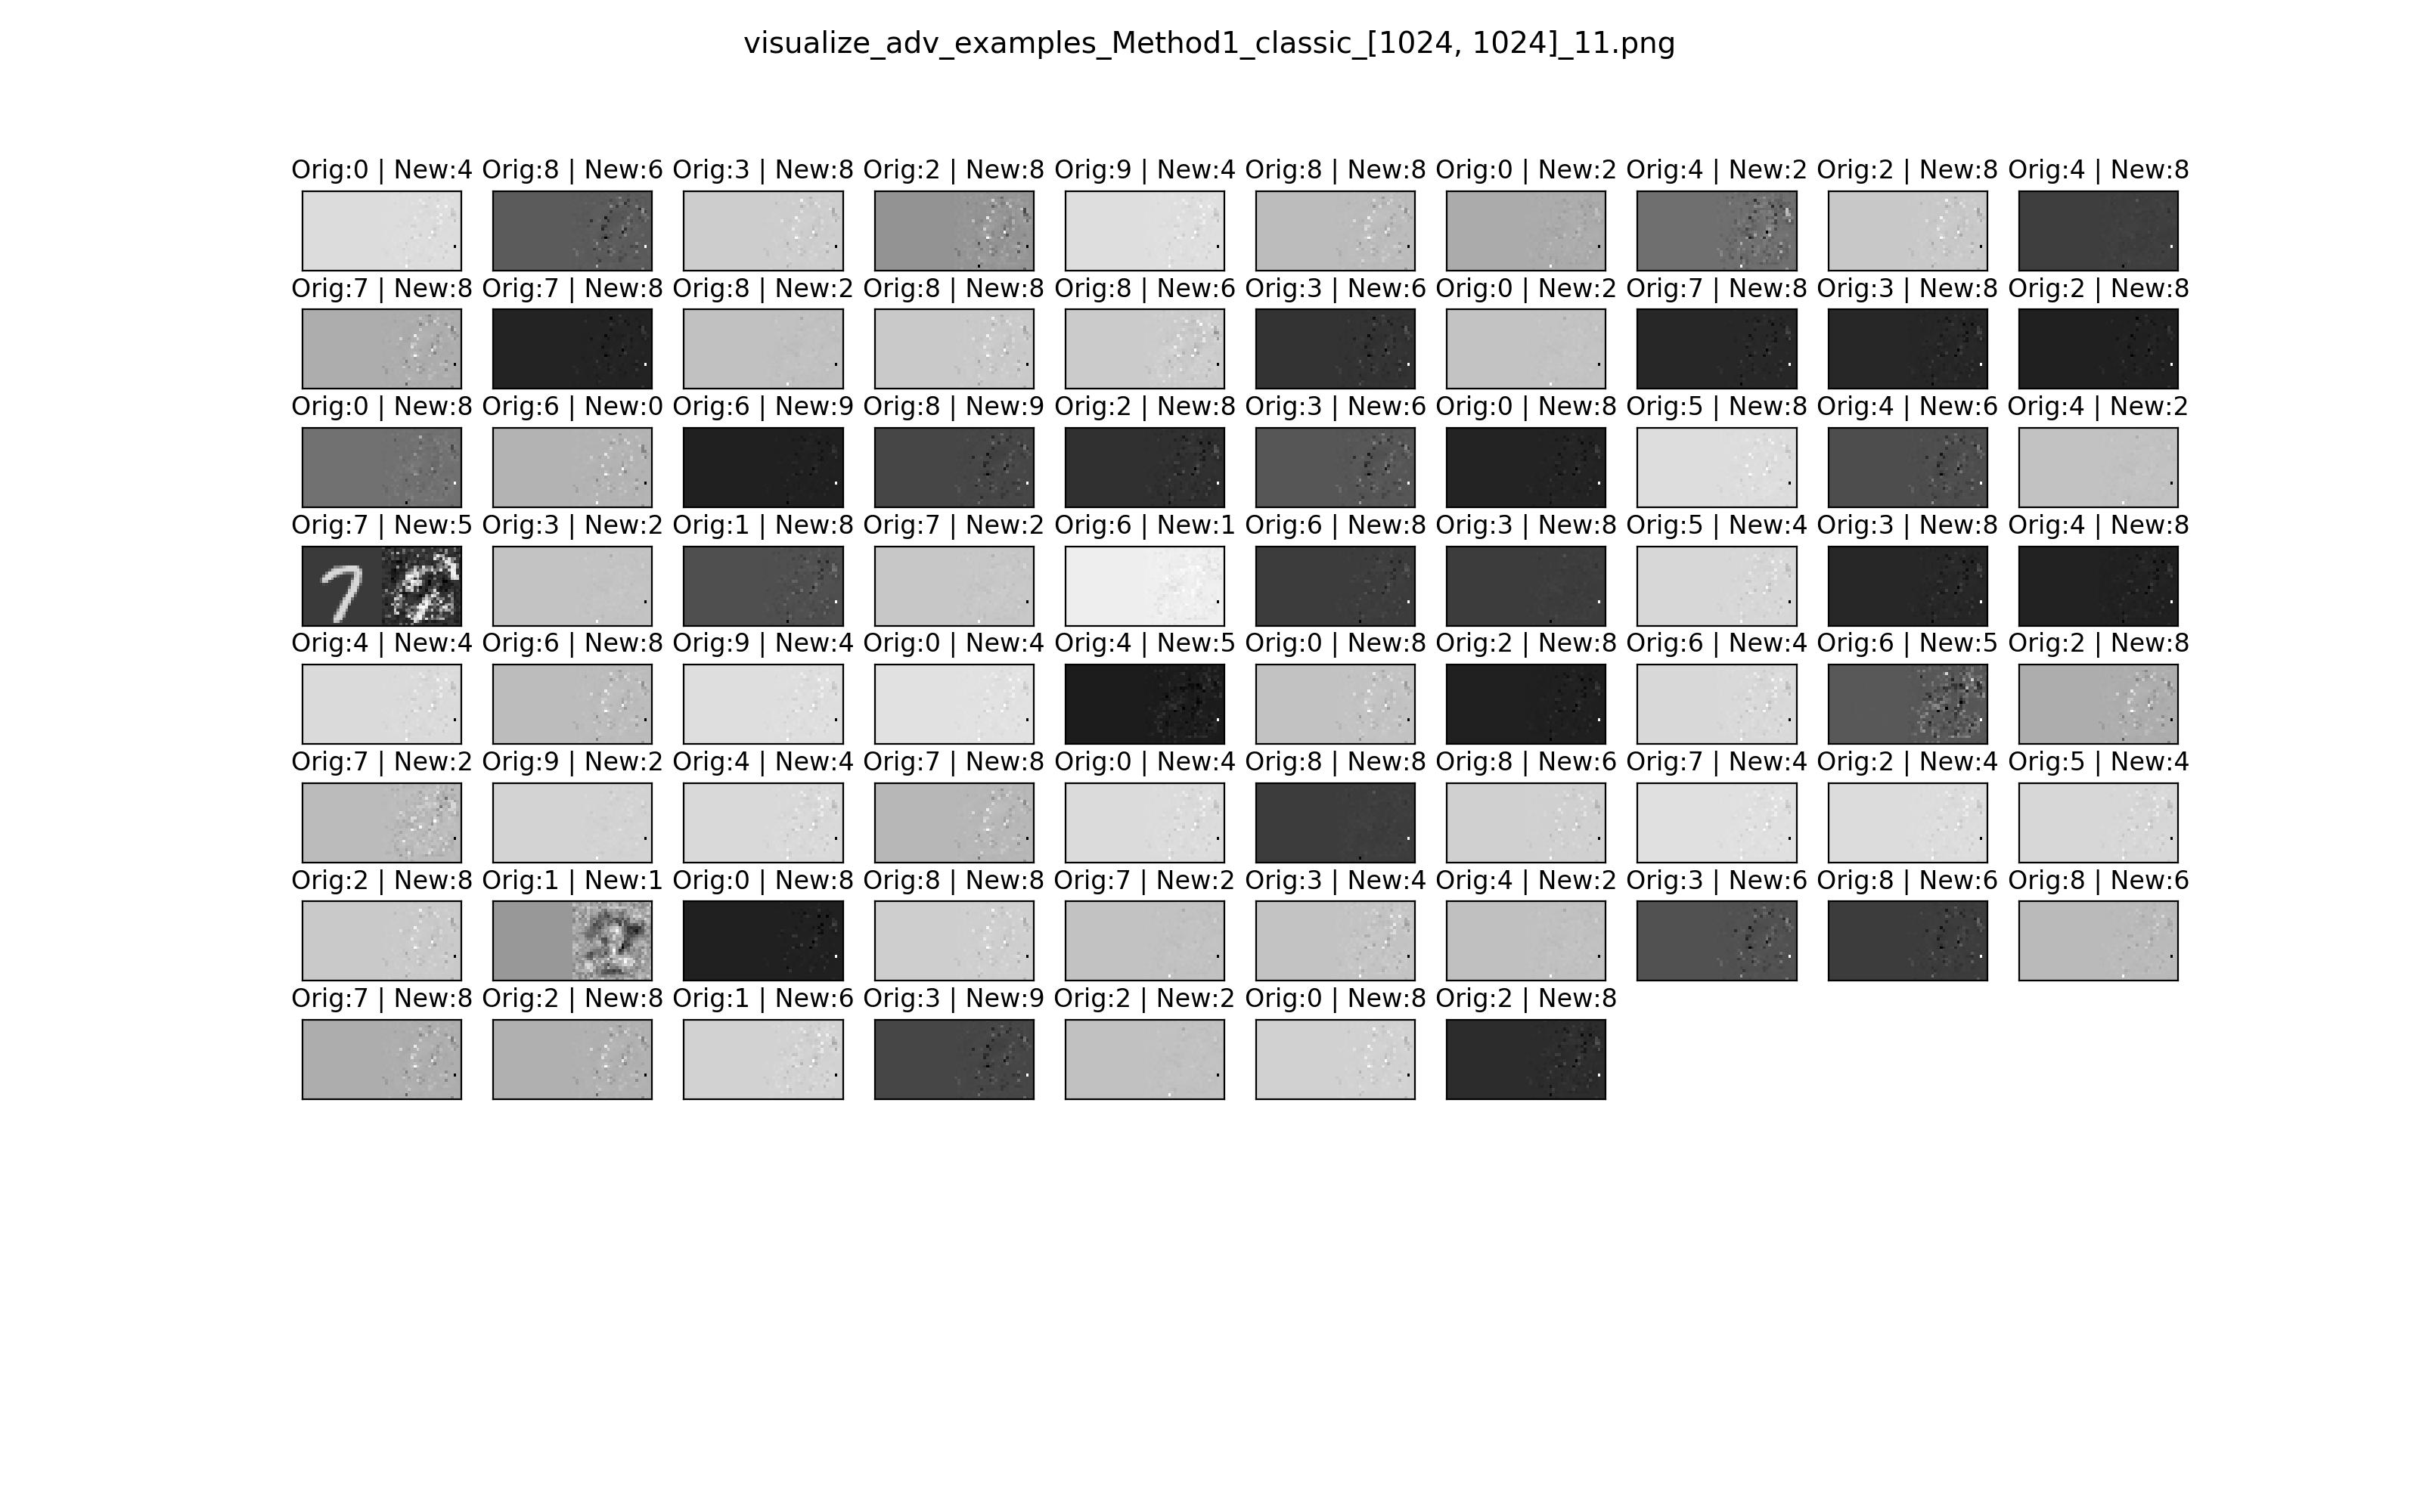

In [28]:
# visualize N random images 
plt.figure(figsize=(16,10))
s = np.min([len(xs),100])
idxs = np.random.choice(range(len(xs)), size=(s,), replace=False)
# idxs = range(len(xs))
for matidx, idx in enumerate(idxs):
    orig_im = xs[idx].reshape(28,28)
    adv_im  = orig_im + noises[idx].reshape(28,28)
    disp_im = np.concatenate((orig_im, adv_im), axis=1)
    plt.subplot(10,10,matidx+1)
    plt.imshow(disp_im, "gray")
    plt.xticks([])
    plt.yticks([])
    plt.suptitle("visualize_adv_examples_Method1_{}_{}_{}.png".format(mode ,hidden_layers, exp_num), fontsize=14)
    plt.title("Orig:{} | New:{}".format(y_trues[idx], y_preds_adversarial[idx]))
plt.savefig('./adversarial_results/visualize_adv_examples_Method1_{}_{}_{}.png'.format(mode ,hidden_layers, exp_num))
plt.show()

In [25]:
# Noise statistics 
noises, xs, y_trues, y_preds = np.array(noises), np.array(xs), np.array(y_trues), np.array(y_preds)
adv_exs = xs + noises
print ("Adv examples: max, min: ", adv_exs.max(), adv_exs.min())
print ("Noise: Mean, Max, Min: ")
print (np.mean(noises), np.max(noises), np.min(noises))

with open("./adversarial_results/stats_adv_noise_Method1_{}_{}_{}.txt".format(mode ,hidden_layers, exp_num), "w") as text_file:
    text_file.write("Adv examples: max, min: {} {}\n".format(adv_exs.max(), adv_exs.min()) )
    text_file.write("Noise: Mean, Max, Min: {} {} {}\n".format(np.mean(noises), np.max(noises), np.min(noises)))

Adv examples: max, min:  1.6726162 -0.662757
Noise: Mean, Max, Min: 
-0.0025265892 0.77222043 -0.8283839


In [19]:
### Now do it for all experiments

for exp_num in range(12):
    for hidden_layers in [[], [8], [128], [1024], [8,8], [128,128], [1024,1024], [8,8,8], [128,128,128], [1024,1024,1024]]:
        for mode in ['fgn', 'classic']:
            
            # check if exists
            if os.path.isfile("./adversarial_results/stats_adv_noise_Method1_{}_{}_{}.txt".format(mode ,hidden_layers, exp_num)):
                print("skipping", mode, str(hidden_layers), str(exp_num))
            else:
            
                print("working on", mode, str(hidden_layers), str(exp_num))

                # define network to attack
                if mode == 'fgn':
                    pre_net = th.Feedforward_FGN_net(hidden_l_nums=hidden_layers, in_feats=28*28, out_feats=10)
                    weights = "./saved_models/Converted_MNIST_Nets/fgn_model_{}_exp_{}_state_dict.pth".format(hidden_layers, exp_num)
                if mode == 'classic':
                    pre_net = th.Classic_MNIST_Net(hidden_l_nums=hidden_layers)
                    weights = "./saved_models/Classic_MNIST_Nets/model_{}_exp_{}_state_dict.pth".format(hidden_layers, exp_num)

                pre_net.load_state_dict(torch.load(weights))

                pre_net.to(device)

                # test accuracy
                th.test(model=pre_net, device=device, test_loader=mnist_test_loader, loss_func=fgn_nll_loss_func, pred_func=fgn_pred_func, verbose=2)
                th.test(model=pre_net, device=device, test_loader=mnist5k_dataloader, loss_func=fgn_nll_loss_func, pred_func=fgn_pred_func, verbose=2)

                # Aggregate
                xs, y_trues, y_preds, y_preds_adversarial, noises = [], [], [], [], []

                # Create attacker for this network
                attacker = Attack(pre_net,device)

                # attack each example
                for x, y_true in zip(images, labels):

                    y_target = random.choice( list(set([0,1,2,3,4,5,6,7,8,9]) - set([y_true])) ) 
                    noise, y_pred, y_pred_adversarial = attacker.attack(x, y_true, y_target, regularization="l2")

                    if y_pred == y_true:
                #         print ("y_pred == y_true, storing to disk")

                        # store
                        xs.append(x)
                        y_trues.append(y_true)
                        y_preds.append(y_pred)
                        y_preds_adversarial.append(y_pred_adversarial)
                        noises.append(noise.squeeze())
                    else: 
                        print ("y_pred != y_true, not storing to disk") 

                # save results
                print("saving results...")
                with open("./adversarial_results/bulk_mnist_adversarial_examples_Method1_{}_{}_{}.pkl".format(mode ,hidden_layers, exp_num),"w") as f: 
                    save_dict = {"xs":xs,
                                 "y_trues":y_trues,
                                 "y_preds":y_preds,
                                 "y_preds_adversarial":y_preds_adversarial,
                                 "noises": noises }
                    pickle.dump(save_dict, f) 


                # visualize N random images 
                print("saving image...")
                plt.figure(figsize=(16,10))
                idxs = np.random.choice(range(500), size=(100,), replace=False)
                for matidx, idx in enumerate(idxs):
                    orig_im = xs[idx].reshape(28,28)
                    adv_im  = orig_im + noises[idx].reshape(28,28)
                    disp_im = np.concatenate((orig_im, adv_im), axis=1)
                    plt.subplot(10,10,matidx+1)
                    plt.imshow(disp_im, "gray")
                    plt.xticks([])
                    plt.yticks([])
                    plt.title("Orig:{} | New:{}".format(y_trues[idx], y_preds_adversarial[idx]))
                plt.savefig('./adversarial_results/visualize_adv_examples_Method1_{}_{}_{}.png'.format(mode ,hidden_layers, exp_num))

                # Noise statistics 
                print("saving noise statistics...")
                noises, xs, y_trues, y_preds = np.array(noises), np.array(xs), np.array(y_trues), np.array(y_preds)
                adv_exs = xs + noises
                print ("Adv examples: max, min: ", adv_exs.max(), adv_exs.min())
                print ("Noise: Mean, Max, Min: ")
                print (np.mean(noises), np.max(noises), np.min(noises))

                with open("./adversarial_results/stats_adv_noise_Method1_{}_{}_{}.txt".format(mode ,hidden_layers, exp_num), "w") as text_file:
                    text_file.write("Adv examples: max, min: {} {}\n".format(adv_exs.max(), adv_exs.min()) )
                    text_file.write("Noise: Mean, Max, Min: {} {} {}\n".format(np.mean(noises), np.max(noises), np.min(noises)))

                print("...done!\n")

skipping fgn [] 0
skipping classic [] 0
skipping fgn [8] 0
skipping classic [8] 0
skipping fgn [128] 0
skipping classic [128] 0
skipping fgn [1024] 0
skipping classic [1024] 0
skipping fgn [8, 8] 0
skipping classic [8, 8] 0
skipping fgn [128, 128] 0
skipping classic [128, 128] 0
skipping fgn [1024, 1024] 0
skipping classic [1024, 1024] 0
skipping fgn [8, 8, 8] 0
skipping classic [8, 8, 8] 0
skipping fgn [128, 128, 128] 0
skipping classic [128, 128, 128] 0
skipping fgn [1024, 1024, 1024] 0
skipping classic [1024, 1024, 1024] 0
skipping fgn [] 1
skipping classic [] 1
skipping fgn [8] 1
skipping classic [8] 1
skipping fgn [128] 1
skipping classic [128] 1
skipping fgn [1024] 1
skipping classic [1024] 1
skipping fgn [8, 8] 1
skipping classic [8, 8] 1
skipping fgn [128, 128] 1
skipping classic [128, 128] 1
skipping fgn [1024, 1024] 1
skipping classic [1024, 1024] 1
skipping fgn [8, 8, 8] 1
skipping classic [8, 8, 8] 1
skipping fgn [128, 128, 128] 1
skipping classic [128, 128, 128] 1
skipping

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
saving results...
saving image...
saving noise statistics...
Adv examples: max, min:  1.1094428 -0.20850039
Noise: Mean, Max, Min: 
-4.7422942e-05 0.1482712 -0.20850039
...done!

working on classic [8] 6
Test set - Average loss: 0.3446, Accuracy: 9030/10000 (90%)
Test set - Average loss: 0.3415, Accuracy: 4522/5000 (90%)
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing t

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
saving results...
saving image...
saving noise statistics...
Adv examples: max, min:  1.6029036 -0.7936922
Noise: Mean, Max, Min: 
-0.0003497023 0.7431594 -0.7936922
...done!

working on fgn [128] 6
Test set - Average loss: 2.2079, Accuracy: 9506/10000 (95%)
Test set - Average loss: 2.2079, Accuracy: 4760/5000 (95%)
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

Test set - Average loss: 0.4646, Accuracy: 9379/10000 (94%)
Test set - Average loss: 0.4628, Accuracy: 4707/5000 (94%)
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred 

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
saving results...
saving image...
saving noise statistics...
Adv examples: max, min:  1.6271677 -0.81476146
Noise: Mean, Max, Min: 
-0.00058935845 1.0845435 -0.9399997
...done!

working on fgn [1024, 1024] 6
Test set - Average loss: 0.1516, Accuracy: 9584/10000 (96%)
Test set - Average loss: 0.1467, Accuracy: 4800/5000 (96%)
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not stori

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
saving results...
saving image...
saving noise statistics...
Adv examples: max, min:  1.5497862 -0.73217225
Noise: Mean, Max, Min: 
-0.00020145433 0.6934149 -0.7828

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
saving results...
saving image...
saving noise statistics...
Adv examples: max, min:  1.5544567 -0.79855675
Noise: Mean, Max, Min: 
-0.0001695839 0.7510294 -0.85844034
...done!

working on fgn [128, 128, 128] 6
Test set - Average loss: 0.8826, Accuracy: 9675/10000 (97%)
Test se

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
saving results...
saving image...
saving noise statistics...
Adv examples: max, min:  1.6249813 -0.6784538
Noise: Mean, Max, Min: 
-0.00064973417 0.8172684 -0.6908847
...done!

working on classic [] 7
Test set - Average loss: 0.2774, Accuracy: 9216/10000 (92%)
Test set - Average loss: 0.2689, Accuracy: 4610/5000 (92%)
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to d

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


saving noise statistics...
Adv examples: max, min:  1.7691534 -0.7382632
Noise: Mean, Max, Min: 
-0.001766604 0.9922409 -0.92284495
...done!

working on fgn [8] 7
Test set - Average loss: 2.2976, Accuracy: 8575/10000 (86%)
Test set - Average loss: 2.2976, Accuracy: 4288/5000 (86%)
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
saving results...
saving image...
saving noise statistics...
Adv examples: max, min:  1.1251694 -0.1687959
Noise: Mean, Max, Min: 
-4.5014916e-05 0.17559116 -0.20003688
...done!

working on classic [8] 7
Test set - Average loss: 0.3608, Accuracy: 8944/10000 (89%)
Test set - Average loss: 0.3598, Accuracy: 4480/5000 (90%)
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing t

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


saving results...
saving image...
saving noise statistics...
Adv examples: max, min:  1.2187011 -0.28701925
Noise: Mean, Max, Min: 
-4.6643207e-05 0.3323972 -0.30857396
...done!

working on classic [128] 7
Test set - Average loss: 0.1268, Accuracy: 9621/10000 (96%)
Test set - Average loss: 0.1250, Accuracy: 4816/5000 (96%)
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
saving results...
saving image...
saving noise statistics...
Adv examples: max, min:  1.8548334 -0.85141027
Noise: Mean, Max, Min: 
-0.0034099966 0.92009073 -1.0499195
...done!

working on fgn [8, 8] 7
Test set - Average loss: 1.4506, Accuracy: 8751/10000 (88%)
Test set - Average loss: 1.4511, Accuracy: 4368/5000 (87%)
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to 

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
saving results...
saving image...
saving noise statistics...
Adv examples: max, min:  1.3973213 -0.52983004
Noise: Mean, Max, Min: 
-6.172378e-05 0.5169906 -0.52983004
...done!

working on classic [8, 8] 7
Test set - Average loss: 0.4063, Accuracy: 8846/10000 (88%)
Test set - Average loss: 0.4066, Accuracy: 4435/5000 (89%)
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

Test set - Average loss: 0.3959, Accuracy: 4459/5000 (89%)
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
saving results...
saving image...
saving noise statistics...
Adv examples: max, min:  1.5486188 -0.70143795
Noise: Mean, Max, Min: 
-0.0002481905 0.69779456 -0.70143795
...done!

working on fgn [128, 128, 128] 7
Test set - Average loss: 0.8739, Accuracy: 9671/10000 (97%)
Test set - Average loss: 0.8725, Accuracy: 4838/5000 (97%)
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not s

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
saving results...
saving image...
saving noise statistics...
Adv examples: max, min:  1.2508302 -0.29015812
Noise: Mean, Max, Min: 
-1.0246764e-05 0.3321539 -0.31361926
...done!

working on classic [128] 8
Test set - Average loss: 0.1293, Accuracy: 9597/10000 (96%)
Test set - Average loss: 0.1261, Accuracy: 4807/5000 (96%)
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
saving results...
saving image...
saving noise statistics...
Adv examples: max, min:  1.1265671 -0.16968758
Noise: Mean, Max, Min: 
-6.9124094e-06 0.19118433 -0.23067485
...done!

working on classic [8] 9
Test set - Average loss: 0.3509, Accuracy: 9032/10000 (90%)
Test set - Average loss: 0.3487, Accuracy: 4528/5000 (91%)
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
saving results...
saving image...
saving noise statistics...
Adv examples: max, min:  1.2282951 -0.30067828
Noise: Mean, Max, Min: 
-3.5725738e-05 0.30304497 -0.31798047
...done!

working on classic [128] 9
Test set - Average loss: 0.1284, Accuracy: 9641/10000 (96%)
Test set - Average loss: 0.1233, Accuracy: 4833/5000 (97%)
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storin

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
saving results...
saving image...
saving noise statistics...
Adv examples: max, min:  1.6423416 -0.87916416
Noise: Mean, Max, Min: 
-0.00080341083 0.85360193 -0.87916416
...done!

working on classic [128, 128] 9
Test set - Average loss: 0.1029, Accuracy: 9676/10000 (97%)
Test set - Average loss: 0.0987, Accuracy: 4845/5000 (97%)
y_pred != y_true, not storing to disk
y_pred != y_true, not s

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
saving results...
saving image...
saving noise statistics...
Adv examples: max, min:  1.5919715 -0.6783873
Noise: Mean, Max, Min: 
-0.000114478746 0.7396724 -0.75924194
...done!

working on classic [128, 128, 128] 9
Test set - Average loss: 0.0913, Accuracy: 9726/10000 (97%)
Test set - Average loss: 0.0890, Accuracy: 4863/5000 (97%)
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, n

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

Test set - Average loss: 0.4273, Accuracy: 9328/10000 (93%)
Test set - Average loss: 0.4262, Accuracy: 4674/5000 (93%)
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred 

y_pred != y_true, not storing to disk


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
saving results...
saving image...
saving noise sta

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
saving results...
saving image...
saving noise statistics...
Adv examples: max, min:  1.674012 -0.7659576
Noise: Mean, Max, Min: 
-0.0008106763 0.7326777 -0.8453156
...done!

working on classic [8, 8, 8] 10
Test set - Average loss: 0.4216, Accuracy: 8850/10000 (88%)
Test set - Average loss: 0.4217, Accuracy: 4427/5000 (89%)
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storin

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
saving results...
saving image...
saving noise statistics...
Adv examples: max, min:  1.8750095 -0.6888631
Noise: Mean, Max, Min: 
-0.0020167858 1.1474793 -1.0223701
...done!

working on fgn [8] 11
Test set - Average loss: 2.2971, Accuracy: 8728/10000 (87%)
Test set - Average loss: 2.2971, Accuracy: 4365/5000 (87%)
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


saving results...
saving image...
saving noise statistics...
Adv examples: max, min:  1.1207129 -0.18637027
Noise: Mean, Max, Min: 
-3.706855e-05 0.1930971 -0.20446445
...done!

working on classic [8] 11
Test set - Average loss: 0.3371, Accuracy: 9033/10000 (90%)
Test set - Average loss: 0.3442, Accuracy: 4503/5000 (90%)
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing t

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
saving results...
saving image...
saving noise statistics...
Adv examples: max, min:  1.7372313 -0.7888606
Noise: Mean, Max, Min: 
-0.0024075022 0.9550671 -0.9941587
...done!

working on classic [1024] 11
Test set - Average loss: 0.1268, Accuracy: 9632/10000 (96%)
Test set - Average loss: 0.1217, Accuracy: 4827/5000 (97%)
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing 

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
saving results...
saving image...
saving noise statistics...
Adv examples: max, min:  1.4010174 -0.4753698
Noise: Mean, Max, Min: 
0.00021825262 0.6777353 -0.56223667
...done!

working on classic [8, 8, 8] 11
Test set - Average loss: 0.3834, Accuracy: 8976/10000 (90%)
Test set - Average loss: 0.3751, Accuracy: 4497/5000 (90%)
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not stor

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_true, not storing to disk
y_pred != y_